### Imports

The following cell imports all necessary libraries/modules

In [22]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

### Creating dataloader

Transforming the data and creating an useful dataloader object to use for training.

In [23]:
class Sprites(Dataset):

    def __init__(self, images: str, transform=None):
        self.images = torch.from_numpy(np.load(images)) / 255
        self.transform = transform

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transform:
            image = self.transform(image)
        return image

In [24]:
BATCH_SIZE = 64

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [26]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Normalize(0.5, 0.5)
])

In [27]:
images = os.path.join("data/sprites.npy")

sprites = Sprites(images=images, transform=transforms)

dataloader = DataLoader(
    dataset=sprites,
    shuffle=True,
    batch_size=BATCH_SIZE,
)

### Looking at the data

In the following cells we take a look at the data

In [28]:
samples = next(iter(dataloader))

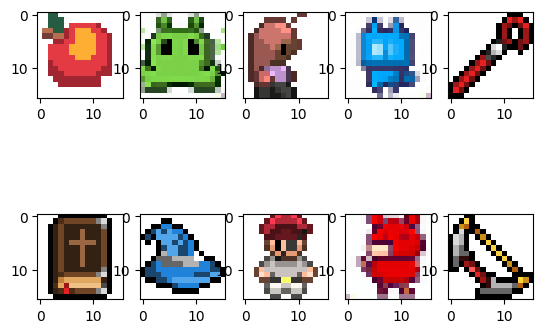

In [29]:
samples = samples[:10,:,:,:] / 2 + 0.5 # Undo the normalization when showing the images

fig, axis = plt.subplots(2, 5)
axis = axis.flatten()

for i in range(10):
    axis[i].imshow(samples[i])

plt.show()

### Creating our networks

Creating the generator and discriminator network and it's necessary blocks and modules.

In [30]:
class PrintShape(nn.Module):
    """
    Neural network model used for debugging the shape.
    """

    def forward(self, x):
        print(x.shape)
        return x

In [31]:
class GeneratorBlock(nn.Module):

    def __init__(
            self,
            in_channels,
            out_channels,
            kernel_size=4,
            stride=2,
            padding=1,
            **kwargs
    ):
        super().__init__(**kwargs)
        self.conv_trans2d = nn.ConvTranspose2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
        )
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()

    def forward(self, x):
        return self.activation(self.batch_norm(self.conv_trans2d(x)))

In [32]:
class Generator(nn.Module):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        n_G = 16
        self.net = nn.Sequential(
            GeneratorBlock(
                in_channels=100,
                out_channels=n_G * 4,
                kernel_size=4,
                stride=1,
                padding=0,
            ), # Output: BATCH_SIZE x 64 x 4 x 4
            GeneratorBlock(
                in_channels=n_G * 4,
                out_channels=n_G * 2,
                kernel_size=4,
                stride=2,
                padding=1,
            ), # Output: BATCH_SIZE x 32 x 8 x 8
            nn.ConvTranspose2d(
                in_channels=n_G * 2,
                out_channels=3,
                kernel_size=4,
                stride=2,
                padding=1
            ), nn.Tanh()  # Output: BATCH_SIZE x 3 x 16 x 16
        )

    def forward(self, x):
        return self.net(x)

In [33]:
class DiscriminatorBlock(nn.Module):

    def __init__(
            self,
            in_channels: int,
            out_channels: int,
            kernel_size: int,
            stride: int,
            padding: int,
            alpha: float,
            **kwargs
    ):

        super().__init__(**kwargs)

        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
        )
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(alpha)

    def forward(self, x):
        return self.activation(self.batch_norm(self.conv(x)))

In [34]:
class Discriminator(nn.Module):

    def __init__(self, alpha: float, **kwargs):
        super().__init__(**kwargs)

        self.net = nn.Sequential(
            DiscriminatorBlock(
                in_channels=3,
                out_channels=16,
                kernel_size=4,
                stride=2,
                padding=1,
                alpha=alpha,
            ),  # Output: BATCH_SIZE x 16 x 8 x 8
            DiscriminatorBlock(
                in_channels=16,
                out_channels=32,
                kernel_size=4,
                stride=2,
                padding=1,
                alpha=alpha,
            ),  # Output: BATCH_SIZE x 32 x 4 x 4
            nn.Conv2d(in_channels=32, out_channels=1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

In [35]:
class GAN:

    def __init__(
            self,
            alpha: float = 0.2,
            lr: float = 0.0002,
            betas: tuple[float, float] = (0.5, 0.999),
            checkpoint: dict = None
    ):
        
        self._gen = Generator().to(device)
        self._dis = Discriminator(alpha).to(device)
        
        self._gen_optim = torch.optim.Adam(
            params=self._gen.parameters(),
            lr=lr,
            betas=betas,
        )
        self._dis_optim = torch.optim.Adam(
            params=self._dis.parameters(),
            lr=lr,
            betas=betas,
        )
        
        if checkpoint:
            self._gen.load_state_dict(checkpoint["gen"], map_location=device)
            self._dis.load_state_dict(checkpoint["dis"], map_location=device)
            self._gen_optim.load_state_dict(checkpoint["gen_optim"], map_location=device)
            self._dis_optim.load_state_dict(checkpoint["dis_optim"], map_location=device)
            self.epochs = checkpoint["epochs"]
        else:
            self.epochs = 0

        self._loss = nn.BCELoss()

    def train(
            self,
            data: DataLoader,
            epochs: int = 10,
            print_losses: bool = True,
    ):

        for epoch in range(epochs):
            D_losses = []
            G_losses = []

            for real_X in tqdm(data, f"Epoch {epoch +1}"):

                batch_size = real_X.shape

                # Updating discriminator
                Z = torch.normal(0, 1, size=(BATCH_SIZE, 100, 1, 1), device=device)

                fake_X = self._gen(Z).detach()
                fake_Y = self._dis(fake_X)

                real_Y = self._dis(real_X.permute(0, 3, 1, 2).to(device))

                ones = torch.ones_like(real_Y)
                zeros = torch.zeros_like(fake_Y)

                D_loss = (self._loss(real_Y, ones) + self._loss(fake_Y, zeros)) / 2
                D_losses.append(D_loss)

                self._dis_optim.zero_grad()
                D_loss.backward()
                self._dis_optim.step()

                # Updating generator
                Z = torch.normal(0, 1, size=(BATCH_SIZE, 100, 1, 1), device=device)

                fake_X = self._gen(Z)
                fake_Y = self._dis(fake_X)

                ones = torch.ones_like(fake_Y)

                G_loss = self._loss(fake_Y, ones)
                G_losses.append(G_loss)

                self._gen_optim.zero_grad()
                G_loss.backward()
                self._gen_optim.step()
                
            self.epochs += 1

            if print_losses:
                print(f"Average discriminator loss: {sum(D_losses) / len(D_losses):5.2f}")
                print(f"Average generator loss: {sum(G_losses) / len(G_losses):5.2f}")

    def generate_images(self, images: int) -> torch.Tensor:

        Z = torch.normal(0, 1, size=(images, 100, 1, 1), device=device)
        with torch.no_grad():
            images = self._gen(Z)
        return images
    
    def save_checkpoint(self, path: str):
        checkpoint = {}
        checkpoint["gen"] = self._gen.state_dict()
        checkpoint["dis"] = self._dis.state_dict()
        checkpoint["gen_optim"] = self._gen_optim.state_dict()
        checkpoint["dis_optim"] = self._dis_optim.state_dict()
        checkpoint["epochs"] = self.epochs
        torch.save(checkpoint, path)

### Training the network

In [37]:
gan = GAN(
    alpha=0.2,
    lr=0.0002,
    betas=(0.5, 0.999),
)

In [54]:
gan.train(
    data=dataloader,
    epochs=99
)

Epoch 1: 100%|██████████| 1397/1397 [00:20<00:00, 67.04it/s]


Average discriminator loss:  0.19
Average generator loss:  3.63


Epoch 2: 100%|██████████| 1397/1397 [00:20<00:00, 68.70it/s]


Average discriminator loss:  0.19
Average generator loss:  3.63


Epoch 3: 100%|██████████| 1397/1397 [00:18<00:00, 73.90it/s]


Average discriminator loss:  0.19
Average generator loss:  3.63


Epoch 4: 100%|██████████| 1397/1397 [00:18<00:00, 75.12it/s]


Average discriminator loss:  0.19
Average generator loss:  3.66


Epoch 5: 100%|██████████| 1397/1397 [00:20<00:00, 69.49it/s]


Average discriminator loss:  0.19
Average generator loss:  3.65


Epoch 6: 100%|██████████| 1397/1397 [00:18<00:00, 73.79it/s]


Average discriminator loss:  0.19
Average generator loss:  3.68


Epoch 7: 100%|██████████| 1397/1397 [00:18<00:00, 74.27it/s]


Average discriminator loss:  0.19
Average generator loss:  3.67


Epoch 8: 100%|██████████| 1397/1397 [00:19<00:00, 71.90it/s]


Average discriminator loss:  0.19
Average generator loss:  3.69


Epoch 9: 100%|██████████| 1397/1397 [00:20<00:00, 69.07it/s]


Average discriminator loss:  0.19
Average generator loss:  3.70


Epoch 10: 100%|██████████| 1397/1397 [00:18<00:00, 75.66it/s]


Average discriminator loss:  0.19
Average generator loss:  3.72


Epoch 11: 100%|██████████| 1397/1397 [00:17<00:00, 77.74it/s]


Average discriminator loss:  0.20
Average generator loss:  3.69


Epoch 12: 100%|██████████| 1397/1397 [00:18<00:00, 76.08it/s]


Average discriminator loss:  0.19
Average generator loss:  3.67


Epoch 13: 100%|██████████| 1397/1397 [00:20<00:00, 67.40it/s]


Average discriminator loss:  0.19
Average generator loss:  3.68


Epoch 14: 100%|██████████| 1397/1397 [00:21<00:00, 65.64it/s]


Average discriminator loss:  0.19
Average generator loss:  3.70


Epoch 15: 100%|██████████| 1397/1397 [00:19<00:00, 71.59it/s]


Average discriminator loss:  0.20
Average generator loss:  3.71


Epoch 16: 100%|██████████| 1397/1397 [00:18<00:00, 74.16it/s]


Average discriminator loss:  0.19
Average generator loss:  3.72


Epoch 17: 100%|██████████| 1397/1397 [00:18<00:00, 77.23it/s]


Average discriminator loss:  0.20
Average generator loss:  3.67


Epoch 18: 100%|██████████| 1397/1397 [00:18<00:00, 75.26it/s]


Average discriminator loss:  0.19
Average generator loss:  3.68


Epoch 19: 100%|██████████| 1397/1397 [00:18<00:00, 75.77it/s]


Average discriminator loss:  0.19
Average generator loss:  3.70


Epoch 20: 100%|██████████| 1397/1397 [00:18<00:00, 76.07it/s]


Average discriminator loss:  0.19
Average generator loss:  3.74


Epoch 21: 100%|██████████| 1397/1397 [00:18<00:00, 75.20it/s]


Average discriminator loss:  0.19
Average generator loss:  3.76


Epoch 22: 100%|██████████| 1397/1397 [00:18<00:00, 75.17it/s]


Average discriminator loss:  0.18
Average generator loss:  3.80


Epoch 23: 100%|██████████| 1397/1397 [00:18<00:00, 74.38it/s]


Average discriminator loss:  0.18
Average generator loss:  3.73


Epoch 24: 100%|██████████| 1397/1397 [00:18<00:00, 76.58it/s]


Average discriminator loss:  0.19
Average generator loss:  3.73


Epoch 25: 100%|██████████| 1397/1397 [00:18<00:00, 74.71it/s]


Average discriminator loss:  0.19
Average generator loss:  3.74


Epoch 26: 100%|██████████| 1397/1397 [00:18<00:00, 76.59it/s]


Average discriminator loss:  0.19
Average generator loss:  3.77


Epoch 27: 100%|██████████| 1397/1397 [00:18<00:00, 77.40it/s]


Average discriminator loss:  0.19
Average generator loss:  3.73


Epoch 28: 100%|██████████| 1397/1397 [00:18<00:00, 75.35it/s]


Average discriminator loss:  0.19
Average generator loss:  3.79


Epoch 29: 100%|██████████| 1397/1397 [00:18<00:00, 76.97it/s]


Average discriminator loss:  0.18
Average generator loss:  3.84


Epoch 30: 100%|██████████| 1397/1397 [00:18<00:00, 75.65it/s]


Average discriminator loss:  0.18
Average generator loss:  3.82


Epoch 31: 100%|██████████| 1397/1397 [00:19<00:00, 71.99it/s]


Average discriminator loss:  0.18
Average generator loss:  3.81


Epoch 32: 100%|██████████| 1397/1397 [00:18<00:00, 75.54it/s]


Average discriminator loss:  0.18
Average generator loss:  3.82


Epoch 33: 100%|██████████| 1397/1397 [00:19<00:00, 72.36it/s]


Average discriminator loss:  0.18
Average generator loss:  3.82


Epoch 34: 100%|██████████| 1397/1397 [00:18<00:00, 76.62it/s]


Average discriminator loss:  0.18
Average generator loss:  3.84


Epoch 35: 100%|██████████| 1397/1397 [00:20<00:00, 69.43it/s]


Average discriminator loss:  0.18
Average generator loss:  3.84


Epoch 36: 100%|██████████| 1397/1397 [00:18<00:00, 75.04it/s]


Average discriminator loss:  0.18
Average generator loss:  3.81


Epoch 37: 100%|██████████| 1397/1397 [00:18<00:00, 75.69it/s]


Average discriminator loss:  0.19
Average generator loss:  3.80


Epoch 38: 100%|██████████| 1397/1397 [00:19<00:00, 70.23it/s]


Average discriminator loss:  0.18
Average generator loss:  3.83


Epoch 39: 100%|██████████| 1397/1397 [00:19<00:00, 71.47it/s]


Average discriminator loss:  0.18
Average generator loss:  3.85


Epoch 40: 100%|██████████| 1397/1397 [00:18<00:00, 73.90it/s]


Average discriminator loss:  0.17
Average generator loss:  3.86


Epoch 41: 100%|██████████| 1397/1397 [00:19<00:00, 69.91it/s]


Average discriminator loss:  0.18
Average generator loss:  3.85


Epoch 42: 100%|██████████| 1397/1397 [00:20<00:00, 69.59it/s]


Average discriminator loss:  0.18
Average generator loss:  3.90


Epoch 43: 100%|██████████| 1397/1397 [00:19<00:00, 71.89it/s]


Average discriminator loss:  0.18
Average generator loss:  3.89


Epoch 44: 100%|██████████| 1397/1397 [00:19<00:00, 72.18it/s]


Average discriminator loss:  0.17
Average generator loss:  3.92


Epoch 45: 100%|██████████| 1397/1397 [00:19<00:00, 73.45it/s]


Average discriminator loss:  0.18
Average generator loss:  3.89


Epoch 46: 100%|██████████| 1397/1397 [00:20<00:00, 69.76it/s]


Average discriminator loss:  0.17
Average generator loss:  3.94


Epoch 47: 100%|██████████| 1397/1397 [00:21<00:00, 66.32it/s]


Average discriminator loss:  0.18
Average generator loss:  3.90


Epoch 48: 100%|██████████| 1397/1397 [00:19<00:00, 69.92it/s]


Average discriminator loss:  0.17
Average generator loss:  3.87


Epoch 49: 100%|██████████| 1397/1397 [00:18<00:00, 74.53it/s]


Average discriminator loss:  0.18
Average generator loss:  3.88


Epoch 50: 100%|██████████| 1397/1397 [00:18<00:00, 74.76it/s]


Average discriminator loss:  0.18
Average generator loss:  3.83


Epoch 51: 100%|██████████| 1397/1397 [00:19<00:00, 73.34it/s]


Average discriminator loss:  0.19
Average generator loss:  3.87


Epoch 52: 100%|██████████| 1397/1397 [00:18<00:00, 76.06it/s]


Average discriminator loss:  0.18
Average generator loss:  3.98


Epoch 53: 100%|██████████| 1397/1397 [00:18<00:00, 75.20it/s]


Average discriminator loss:  0.19
Average generator loss:  3.96


Epoch 54: 100%|██████████| 1397/1397 [00:18<00:00, 73.62it/s]


Average discriminator loss:  0.18
Average generator loss:  3.91


Epoch 55: 100%|██████████| 1397/1397 [00:18<00:00, 73.71it/s]


Average discriminator loss:  0.18
Average generator loss:  3.92


Epoch 56: 100%|██████████| 1397/1397 [00:20<00:00, 68.46it/s]


Average discriminator loss:  0.18
Average generator loss:  3.90


Epoch 57: 100%|██████████| 1397/1397 [00:18<00:00, 75.41it/s]


Average discriminator loss:  0.19
Average generator loss:  3.88


Epoch 58: 100%|██████████| 1397/1397 [00:18<00:00, 75.42it/s]


Average discriminator loss:  0.19
Average generator loss:  3.89


Epoch 59: 100%|██████████| 1397/1397 [00:19<00:00, 70.63it/s]


Average discriminator loss:  0.18
Average generator loss:  3.91


Epoch 60: 100%|██████████| 1397/1397 [00:19<00:00, 73.03it/s]


Average discriminator loss:  0.19
Average generator loss:  3.90


Epoch 61: 100%|██████████| 1397/1397 [00:19<00:00, 73.09it/s]


Average discriminator loss:  0.19
Average generator loss:  3.91


Epoch 62: 100%|██████████| 1397/1397 [00:20<00:00, 69.77it/s]


Average discriminator loss:  0.18
Average generator loss:  3.92


Epoch 63: 100%|██████████| 1397/1397 [00:19<00:00, 71.01it/s]


Average discriminator loss:  0.18
Average generator loss:  3.97


Epoch 64: 100%|██████████| 1397/1397 [00:19<00:00, 71.45it/s]


Average discriminator loss:  0.18
Average generator loss:  3.93


Epoch 65: 100%|██████████| 1397/1397 [00:18<00:00, 73.58it/s]


Average discriminator loss:  0.18
Average generator loss:  3.97


Epoch 66: 100%|██████████| 1397/1397 [00:18<00:00, 74.41it/s]


Average discriminator loss:  0.18
Average generator loss:  3.99


Epoch 67: 100%|██████████| 1397/1397 [00:18<00:00, 73.73it/s]


Average discriminator loss:  0.18
Average generator loss:  3.95


Epoch 68: 100%|██████████| 1397/1397 [00:19<00:00, 70.76it/s]


Average discriminator loss:  0.18
Average generator loss:  3.96


Epoch 69: 100%|██████████| 1397/1397 [00:18<00:00, 74.28it/s]


Average discriminator loss:  0.18
Average generator loss:  3.92


Epoch 70: 100%|██████████| 1397/1397 [00:18<00:00, 74.60it/s]


Average discriminator loss:  0.18
Average generator loss:  3.87


Epoch 71: 100%|██████████| 1397/1397 [00:19<00:00, 71.04it/s]


Average discriminator loss:  0.18
Average generator loss:  3.92


Epoch 72: 100%|██████████| 1397/1397 [00:19<00:00, 73.42it/s]


Average discriminator loss:  0.18
Average generator loss:  3.92


Epoch 73: 100%|██████████| 1397/1397 [00:19<00:00, 72.53it/s]


Average discriminator loss:  0.19
Average generator loss:  3.90


Epoch 74: 100%|██████████| 1397/1397 [00:20<00:00, 69.54it/s]


Average discriminator loss:  0.19
Average generator loss:  3.90


Epoch 75: 100%|██████████| 1397/1397 [00:19<00:00, 70.51it/s]


Average discriminator loss:  0.19
Average generator loss:  3.87


Epoch 76: 100%|██████████| 1397/1397 [00:19<00:00, 69.98it/s]


Average discriminator loss:  0.19
Average generator loss:  3.91


Epoch 77: 100%|██████████| 1397/1397 [00:20<00:00, 68.99it/s]


Average discriminator loss:  0.19
Average generator loss:  3.94


Epoch 78: 100%|██████████| 1397/1397 [00:19<00:00, 69.89it/s]


Average discriminator loss:  0.19
Average generator loss:  3.94


Epoch 79: 100%|██████████| 1397/1397 [00:19<00:00, 71.48it/s]


Average discriminator loss:  0.19
Average generator loss:  3.92


Epoch 80: 100%|██████████| 1397/1397 [00:20<00:00, 69.03it/s]


Average discriminator loss:  0.19
Average generator loss:  3.92


Epoch 81: 100%|██████████| 1397/1397 [00:21<00:00, 65.96it/s]


Average discriminator loss:  0.19
Average generator loss:  3.89


Epoch 82: 100%|██████████| 1397/1397 [00:20<00:00, 67.70it/s]


Average discriminator loss:  0.20
Average generator loss:  3.85


Epoch 83: 100%|██████████| 1397/1397 [00:20<00:00, 69.79it/s]


Average discriminator loss:  0.19
Average generator loss:  3.93


Epoch 84: 100%|██████████| 1397/1397 [00:21<00:00, 65.54it/s]


Average discriminator loss:  0.19
Average generator loss:  3.91


Epoch 85: 100%|██████████| 1397/1397 [00:19<00:00, 72.10it/s]


Average discriminator loss:  0.20
Average generator loss:  3.94


Epoch 86: 100%|██████████| 1397/1397 [00:19<00:00, 72.19it/s]


Average discriminator loss:  0.20
Average generator loss:  3.91


Epoch 87: 100%|██████████| 1397/1397 [00:19<00:00, 70.83it/s]


Average discriminator loss:  0.20
Average generator loss:  3.88


Epoch 88: 100%|██████████| 1397/1397 [00:20<00:00, 69.85it/s]


Average discriminator loss:  0.20
Average generator loss:  3.87


Epoch 89: 100%|██████████| 1397/1397 [00:20<00:00, 69.65it/s]


Average discriminator loss:  0.19
Average generator loss:  3.87


Epoch 90: 100%|██████████| 1397/1397 [00:19<00:00, 71.71it/s]


Average discriminator loss:  0.19
Average generator loss:  3.88


Epoch 91: 100%|██████████| 1397/1397 [00:20<00:00, 69.64it/s]


Average discriminator loss:  0.19
Average generator loss:  3.90


Epoch 92: 100%|██████████| 1397/1397 [00:19<00:00, 70.57it/s]


Average discriminator loss:  0.19
Average generator loss:  3.86


Epoch 93: 100%|██████████| 1397/1397 [00:19<00:00, 70.52it/s]


Average discriminator loss:  0.20
Average generator loss:  3.88


Epoch 94: 100%|██████████| 1397/1397 [00:19<00:00, 70.43it/s]


Average discriminator loss:  0.20
Average generator loss:  3.88


Epoch 95: 100%|██████████| 1397/1397 [00:19<00:00, 71.50it/s]


Average discriminator loss:  0.20
Average generator loss:  3.84


Epoch 96: 100%|██████████| 1397/1397 [00:20<00:00, 67.78it/s]


Average discriminator loss:  0.20
Average generator loss:  3.84


Epoch 97: 100%|██████████| 1397/1397 [00:20<00:00, 68.49it/s]


Average discriminator loss:  0.20
Average generator loss:  3.86


Epoch 98: 100%|██████████| 1397/1397 [00:19<00:00, 70.28it/s]


Average discriminator loss:  0.20
Average generator loss:  3.86


Epoch 99: 100%|██████████| 1397/1397 [00:20<00:00, 69.42it/s]


Average discriminator loss:  0.20
Average generator loss:  3.83


### Inspecting results
Checking if our model did pookie

In [92]:
Z = torch.normal(0, 1, size=(15, 100, 1, 1), device=device)

with torch.no_grad():
    images = gan._gen(Z)
    labels = gan._dis(images)

images = images.permute(0, 2, 3, 1)/2+0.5

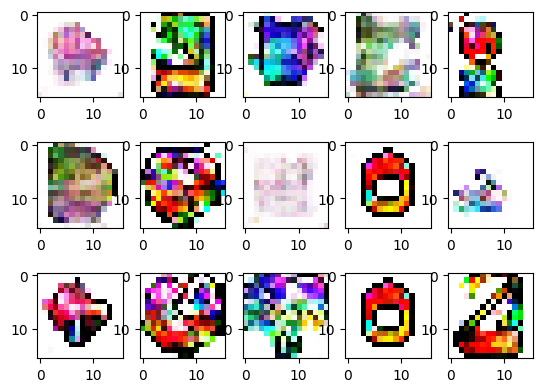

In [93]:
fig, axis = plt.subplots(3, 5)
axis = axis.flatten()

for i in range(15):
    axis[i].imshow(images.cpu()[i])

plt.show()